In [5]:
# Make sure we are at the root of working directory
%cd ..

d:\MasterDegree\AMR\amr-parser


In [6]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import matplotlib.pyplot as plt
import random
import penman
import pickle 
import math

from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix , f1_score, accuracy_score, precision_recall_fscore_support

from IPython.display import Image  
from tqdm.auto import tqdm

from xgboost import XGBClassifier

RANDOM_STATE = 13516013
random.seed(RANDOM_STATE)
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [8]:
# data_path = "data/raw/edge_prediction/dependency_parser_features_labeled.csv"
data_path = "data/raw/edge_prediction/dependency_parser_features_labeled_no_unk.csv"
test_data_path = "data/raw/edge_prediction/test_dependency_parser_features_labeled.csv"
amr_data_path = "data/raw/edge_prediction/amr.csv"
amr_test_path = "data/raw/edge_prediction/amr.test.csv"

amr_val_prediction_path = 'data/test/val'
amr_test_prediction_path = 'data/test/test'


feature_filter_type = ['positional']

In [9]:
dependency_features_df = pd.read_csv(data_path)
amr_dataset = pd.read_csv(amr_data_path)
test_amr_dataset = pd.read_csv(amr_test_path)

In [10]:
def feature_selection(dataset, filter_type='all'):
    lexical_features = ['parent', 'child']
    positional_features = ['parent_position', 'child_position']
    structural_features = ['parent_pos', 'child_pos']
    syntactic_features = ['dependency_role']
    ner_features = ['parent_ner', 'child_ner']
    
    selected_dataset = dataset
    
    if filter_type != 'all':
        if 'lexical' in filter_type:
            selected_dataset = selected_dataset.drop(lexical_features, axis=1)
        if 'positional' in filter_type:
            selected_dataset = selected_dataset.drop(positional_features, axis=1)
        if 'syntactic' in filter_type:
            selected_dataset = selected_dataset.drop(syntactic_features+structural_features, axis=1)
        if 'ner' in filter_type:
            selected_dataset = selected_dataset.drop(ner_features, axis=1)
        
    return selected_dataset

## Cross Validations

In [12]:
def custom_dependency_parser_feature_k_fold(dataset, n_split, shuffle=False):
    min_sentence_id = dataset.min()['sentence_id']
    max_sentence_id = dataset.max()['sentence_id']
    sentence_num = max_sentence_id
    
    sentence_ids = np.arange(min_sentence_id, max_sentence_id+1)
    if (shuffle):
        np.random.seed(RANDOM_STATE)
        np.random.shuffle(sentence_ids)
    
    cur_sentence_id = min_sentence_id
    split_size = sentence_num // n_split
    
    indexes = []
    while (cur_sentence_id < max_sentence_id):
        stop_sentence_id = min(cur_sentence_id + split_size-1, sentence_num)
        test_sentence_ids = sentence_ids[cur_sentence_id:stop_sentence_id+1]
        
        test_condition = dataset.sentence_id.isin(test_sentence_ids)
        train_condition = ~test_condition 
        
        indexes.append((dataset[train_condition].index, dataset[test_condition].index))
        cur_sentence_id = stop_sentence_id
    
    return indexes
    
def split_sentence(dataset, split):
    random.seed(RANDOM_STATE)
    sentence_num = dataset.max()['sentence_id']
    train_length = round(sentence_num*(100-(split*100))/100)
    sentence_indexes = random.sample(range(1, sentence_num+1), int(train_length))    
    data_train, data_val = dataset[dataset.sentence_id.isin(sentence_indexes)], dataset[~dataset.sentence_id.isin(sentence_indexes)]
    label = ['label']
    return data_train.drop(label, axis=1), data_val.drop(label, axis=1), data_train[label], data_val[label]
    

### Save Val AMR data 

In [13]:
def save_amr_data(amr_data, filepath):
    with open(filepath + '.txt', 'w+', encoding='utf-8') as f:
        for idx, amr_graph in amr_data.values:
            f.write(amr_graph)
            f.write('\n\n')

# Encoder

### Label Encoder

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(dependency_features_df['label'])
labels = label_encoder.classes_

### One Hot Encoder

In [15]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

filtered_dependency_features_df = feature_selection(dependency_features_df, feature_filter_type)
one_hot_feature_names = ['parent_ner', 'child_ner', 'parent_pos', 'dependency_role','child_pos']
one_hot_features = list(filtered_dependency_features_df.columns[filtered_dependency_features_df.columns.isin(one_hot_feature_names)])
one_hot_encoder.fit(dependency_features_df[one_hot_features])

OneHotEncoder(handle_unknown='ignore')

In [16]:

list(zip(one_hot_feature_names, [len(i) for i in one_hot_encoder.categories_]))

[('parent_ner', 11),
 ('child_ner', 12),
 ('parent_pos', 13),
 ('dependency_role', 16),
 ('child_pos', 15)]

## Load Word Embedding

In [17]:
word_vec_model = gensim.models.Word2Vec.load('pretrained/word2vec/id/id.bin.gz')
word_vec = word_vec_model.wv

### Preprocess Features

In [18]:
def preprocess(X_train, word_vec, one_hot_encoder):
    
    word_feature_names = ['parent', 'child']
    one_hot_feature_names = ['parent_ner', 'child_ner', 'parent_pos', 'dependency_role', 'child_pos']
    
    word_features = list(X_train.columns[X_train.columns.isin(word_feature_names)])
    one_hot_features = list(X_train.columns[X_train.columns.isin(one_hot_feature_names)])
    
    def check_word_features(X):
        columns = [column in word_features for column in X.columns]
        return any(columns)

    contains_word_features = check_word_features(X_train)
    
    X_train_dropped = X_train
    if (contains_word_features):
        X_train_dropped = X_train.drop(word_features+one_hot_features, axis=1)
    else:
        X_train_dropped = X_train.drop(one_hot_features, axis=1)
    
    if contains_word_features:
        X_train_word_data = X_train[word_features]
        # load word embedding
        embeddings = []
        for data in X_train_word_data.values:
            current_embedding = []
            for word in data:
                splitted_word = word.split('_')[0]
                if splitted_word in word_vec:
                    current_embedding.append(word_vec[splitted_word])
                else:
                    none = [0] * 300
                    current_embedding.append(none)
            embeddings.append(current_embedding)
    
    # load one hot encoder
    X_train_one_hot_data = X_train[one_hot_features]
    X_train_one_hot_encoded = one_hot_encoder.transform(X_train_one_hot_data).toarray()
    
    X_train = []
    for idx, row in enumerate(X_train_dropped.values):
        concatenated = None
        if (contains_word_features):
            concatenated = np.concatenate([row, X_train_one_hot_encoded[idx], embeddings[idx][0],embeddings[idx][1]])
        else:
            concatenated = np.concatenate([row, X_train_one_hot_encoded[idx]])
            
        X_train.append(concatenated)
    
    return X_train

### Train Model

In [37]:
def fit_predict_model(model_name, X_train, y_train, X_val, y_val, params):
    supported_model_name = ['dtc', 'xgb']
    if model_name not in supported_model_name:
        raise Exception("Model not supported")

    if model_name == 'dtc':
        model = DecisionTreeClassifier(random_state=RANDOM_STATE, **params)
    elif model_name == 'xgb':
        if not params:
            params = {}
        model = XGBClassifier(**params)
    # Do training
    model = model.fit(np.array(X_train), np.array(y_train))
    # Do predict with val data
    y_val_pred = model.predict(np.array(X_val))
    
    return model, y_val_pred

def preprocess_features(X, y, one_hot_encoder, label_encoder):
    # Preprocess features
    X = preprocess(X, word_vec, one_hot_encoder)
    # Preprocess labels
    y = label_encoder.transform(np.ravel(y))

    return X, y

def run_hold_out_validation(dataset, split_percent, word_vec, label_encoder, one_hot_encoder,  model_name='dtc', params=None):
    X_train, X_val, y_train, y_val = split_sentence(dataset, split_percent)
    
    # preprocess features
    X_train, y_train = preprocess_features(X_train, y_train, one_hot_encoder, label_encoder)
    X_val, y_val = preprocess_features(X_val, y_val, one_hot_encoder, label_encoder)

    model, y_val_pred = fit_predict_model(model_name, X_train, y_train, X_val, y_val, params)
    performance = get_metrics(y_val, y_val_pred, label_encoder)

    return model, performance 

def build_amr_from_prediction(X,y):
    predictions = create_pediction_graph(X, y)
    amr_graphs = []
    for idx, prediction in enumerate(predictions):
        graph = create_amr_graph_from_prediction(prediction)
        amr_graphs.append(graph)
    return amr_graphs    

def get_smatch_score(filepath):
    smatch_output = !python tools/smatch/smatch.py -f {filepath}.pred.txt {filepath}.txt --significant 3
    print(smatch_output)
    f_score = float(smatch_output[0].split(' ')[1])
    # smatch_output=[]
    # %run tools/smatch/smatch.py -f {filepath}.pred.txt {filepath}.txt --significant 3
    # with open('best_f_score_smatch.txt') as f:
    #     for line in f:
    #         smatch_output.append(line)

    # f_score = float(smatch_output[0].split(' ')[1])
    return f_score

def run_k_fold_validation(dataset, n_split, word_vec, label_encoder, one_hot_encoder, shuffle=False, feature_filter='all', model_name='dtc', params=None):
    folds = custom_dependency_parser_feature_k_fold(dataset, n_split, shuffle=shuffle)
    label = ['label']
    
    performances = defaultdict(list)
    
    for train_idx, val_idx in folds:
        train_dataset, val_dataset = dataset.iloc[train_idx], dataset.iloc[val_idx]
        X_train, y_train = train_dataset.drop(label, axis=1), train_dataset[label]
        X_val, y_val = val_dataset.drop(label, axis=1), val_dataset[label]
        
        filtered_X_train = feature_selection(X_train, feature_filter)
        filtered_X_val = feature_selection(X_val, feature_filter)
        
        # save AMR Data
        amr_val_df = amr_dataset[amr_dataset.sentence_id.isin(X_val.sentence_id.unique())]
        save_amr_data(amr_val_df, amr_val_prediction_path)
        
        # preprocess features
        X_train_processed, y_train_processed = preprocess_features(filtered_X_train, y_train, one_hot_encoder, label_encoder)
        X_val_processed, y_val_processed = preprocess_features(filtered_X_val, y_val, one_hot_encoder, label_encoder)
        
        model, y_val_pred = fit_predict_model(model_name, X_train_processed, y_train_processed, X_val_processed, y_val_processed, params)
        performance = get_metrics(y_val_processed, y_val_pred, label_encoder)

        # build prediction
        amr_graphs = build_amr_from_prediction(X_val, y_val_pred)
        save_amr_graphs(amr_graphs, amr_val_prediction_path)
        f_score = get_smatch_score(amr_val_prediction_path)
        
        for key in performance:
            performances[key].append(performance[key])
        performances['smatch'].append(f_score)
    
    for key in performances:
        performances[key] = np.mean(performances[key])
    
    return model, performances
      
def get_metrics(y_test, y_pred, label_encoder):
    
    y_true, y_pred = label_encoder.inverse_transform(y_test),label_encoder.inverse_transform(y_pred) 
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
#     precision_recall_fscore_support_score = precision_recall_fscore_support(y_true, y_pred)
    
    labels = label_encoder.classes_
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    return dict(
        f1_micro=f1_micro, 
        f1_macro=f1_macro, 
        accuracy=accuracy,
#         precision_recall_fscore_support_score=precision_recall_fscore_support,
#         cm=cm
    )

def print_performance_metrics(performance, labels):
    accuracy = performance['accuracy']
    f1_macro = performance['f1_macro']
    f1_micro = performance['f1_micro']
    smatch = performance.get('smatch', 0)
    
#     cm = performance['cm']
    
    print("Accuracy: {:.3f}\nF1 Micro : {:.3f}\nF1 Macro: {:.3f}\nSMATCH: {:.3f}".format(accuracy,f1_micro, f1_macro, smatch))
#     print(performance['precision_recall_fscore_support_score'])


## Post Process

In [21]:
def create_pediction_graph(X_test, y_pred):
    predictions = []
#     X_test_val = X_test.values
    cur_sentence_id = X_test['sentence_id'].values[0]
    i = 0

    while i < len(y_pred):
        prediction = {
            'nodes': [],
            'heads': [],
            'corefs': [],
            'head_labels': [],
            'sentence_id': 0
        }
        
        current_pairs = []
        root = None
        # Collect nodes
        while i < len(y_pred) and cur_sentence_id == X_test['sentence_id'].values[i]:
            # add nodes
            parent = X_test['parent'].values[i]
            child = X_test['child'].values[i]
            is_root = X_test['is_root'].values[i]
            
            if root is None and is_root==1:
                root = parent
            
            if (parent not in prediction['nodes']):
                prediction['nodes'].append(parent)
            if (child not in prediction['nodes']):
                prediction['nodes'].append(child)
            current_pairs.append((parent, child, y_pred[i]))    
            i+=1
        
        # Collect heads
        for node in prediction['nodes']:
            if node == root:
                prediction['heads'].append(0)
                prediction['head_labels'].append(':root')
            else:
                for pair in current_pairs:
                    if (pair[1] == node):
                        prediction['heads'].append(prediction['nodes'].index(pair[0])+1)
                        prediction['head_labels'] += list(label_encoder.inverse_transform([pair[2]]))

        prediction['corefs'] = list(range(1, len(prediction['nodes'])+1))
        prediction['sentence_id'] = cur_sentence_id
        prediction['root'] = root
        
        predictions.append(prediction)
        if (i < len(y_pred)):
            cur_sentence_id = X_test['sentence_id'].values[i]

    return predictions

def create_amr_graph_from_prediction(prediction):
    nodes = prediction['nodes']
    heads = prediction['heads']
    head_labels = prediction['head_labels']
    sentence_id = prediction['sentence_id']
    root = prediction['root']
    
    
    variable_map = dict()
    triples = []
    for idx, node in enumerate(nodes):
        variable_map['vv'+str(idx+1)] = node
    
    # find top 
    top = 'vv1'
    for var, value in variable_map.items():
        if value == root:
            top = var
    
    # rename nodes
    for key in variable_map:
        variable_map[key] = variable_map[key].split('_')[0]
    
    # create instances
    for variable in variable_map:
        triples.append((variable, 'instance', variable_map[variable]))

    # create connections
    for idx, head in enumerate(heads):
        if (head != 0):
            head_var = 'vv{}'.format(head)
            dep_var = 'vv{}'.format(idx+1)
            label = head_labels[idx]
            triple = (head_var, label, dep_var)
            triples.append(triple)
        
    graph = penman.Graph()
    
    graph.heads = heads
    graph.nodes = nodes
    graph.head_labels = head_labels
    graph._top = top
    graph._triples = [penman.Triple(*t) for t in triples]
    graph.id = sentence_id
    
    return graph
    
def save_amr_graphs(amr_graphs, filepath):
    with open(filepath + '.pred.txt', 'w+', encoding='utf-8') as f:
        for idx, amr_graph in enumerate(amr_graphs):
            try:
                f.write(str(amr_graph))
                f.write('\n\n')
            except Exception as e:
                display(amr_graph.id)
                display(amr_graph._top)
                display(amr_graph._triples)
                display(amr_graph.nodes)                                                
                display(amr_graph.heads)
                display(amr_graph.head_labels)                                                

In [22]:
def create_experiment_report(experiments):
    report_dict = defaultdict(list)
    
    for experiment in experiments:
        report_dict['model_name'].append(experiment.name)
        report_dict['accuracy'].append(experiment.performance['accuracy'])
        report_dict['f1_macro'].append(experiment.performance['f1_macro'])
        report_dict['smatch'].append(experiment.performance['smatch'])
    
    report_df = pd.DataFrame(report_dict)
    report_df = report_df.set_index('model_name')
    return report_df

In [42]:
class TrainingModel:
    def __init__(self, name, model, performance, labels):
        self.name = name
        self.model = model
        self.performance = performance
        self.labels = labels
    
    def __gt__(self, model2):
        return self.performance['f1_macro'] > model2.performance['f1_macro']
    
    def print_metrics(self):
        print("----{}----".format(self.name))
        print()
        print_performance_metrics(self.performance, self.labels)
    
    def save(self):
        best_model_filename = "saved_model/{}_best.pickle.dat".format(self.name)
        with open(best_model_filename, 'wb+') as f:
            pickle.dump(self.model,f)

class ExperimentParams:
    def __init__(self, model_name, model_params):
        self.model_name = model_name
        self.model_params = model_params

### initialize Training Params

In [26]:
experiment_params = []

experiment_params.append(ExperimentParams(model_name='xgb', model_params=[
#     {"learning_rate" : 0.05, 'max_depth': 5},
#     {"learning_rate" : 0.05, 'max_depth': 8 },
#     {"learning_rate" : 0.05, 'max_depth': 10},
#     {"learning_rate" : 0.10, 'max_depth': 5 },
    {"learning_rate" : 0.10, 'max_depth': 8},
#     {"learning_rate" : 0.10, 'max_depth': 10},
#     {"learning_rate" : 0.20, 'max_depth': 5},
#     {"learning_rate" : 0.20, 'max_depth': 8},
#     {"learning_rate" : 0.20, 'max_depth': 10},
]))

# experiment_params.append(ExperimentParams(model_name='dtc', model_params=[
#     {'max_depth': 6 , 'criterion': 'entropy'},
#     {'max_depth': 6 , 'criterion': 'gini'},
#     {'max_depth': 7 , 'criterion': 'entropy'},
#     {'max_depth': 7 , 'criterion': 'gini'}, 
#     {'max_depth': 10 , 'criterion': 'entropy'},
#     {'max_depth': 10 , 'criterion': 'gini'},
#     {'max_depth': 12 , 'criterion': 'entropy'},
#     {'max_depth': 12 , 'criterion': 'gini'}
# ]))

## Hold Out 

In [ ]:
# SPLIT_PERCENT = 0.20

# trained_models = []
# experiment_tqdm = tqdm(experiment_params)
# for experiment_param in experiment_tqdm:
#     for model_param in experiment_param.model_params: 
#         model, performance = run_hold_out_validation(dependency_features_df,
#                                                    split_percent=SPLIT_PERCENT,
#                                                    word_vec=word_vec,
#                                                    label_encoder=label_encoder,
#                                                    one_hot_encoder=one_hot_encoder,
#                                                    model_name=experiment_param.model_name, 
#                                                    params=model_param)
#         model_param_string = ''
#         if (model_param is not None):
#             model_param_string = '_'.join(["{}_{}".format(key, model_param[key]) for key in model_param])
#         model_name = experiment_param.model_name + '_' + model_param_string
        
#         trained_models.append(TrainingModel(model_name, model, performance, labels))

## K Fold

In [38]:
K_SPLIT = 5

trained_models = []
experiment_tqdm = tqdm(experiment_params)
for experiment_param in experiment_tqdm:
    train_tqdm = tqdm(experiment_param.model_params)
    for model_param in train_tqdm: 
        model, performance = run_k_fold_validation(dependency_features_df,
                                                   n_split=K_SPLIT,
                                                   shuffle=True,
                                                   word_vec=word_vec,
                                                   label_encoder=label_encoder,
                                                   one_hot_encoder=one_hot_encoder,
                                                   feature_filter=feature_filter_type,
                                                   model_name=experiment_param.model_name, 
                                                   params=model_param)
        model_param_string = ''
        if (model_param is not None):
            model_param_string = '_'.join(["{}_{}".format(key, model_param[key]) for key in model_param])
        model_name = experiment_param.model_name + '_' + model_param_string
        trained_models.append(TrainingModel(model_name, model, performance, labels))

  0%|          | 0/1 [00:00<?, ?it/s]D:\miniconda3\envs\amr\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['ARG0' 'ARG1' 'location' 'mod' 'name' 'time'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
['F-score: 0.838']
D:\miniconda3\envs\amr\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['ARG0' 'ARG1' 'location' 'mod' 'name' 'time'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
['F-score: 0.848']
D:\miniconda3\envs\amr\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['ARG0' 'ARG1' 'location' 'mod' 'name' 'time'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warni

In [39]:
print(feature_filter_type)
report_df = create_experiment_report(trained_models)
report_df

['positional']


,accuracy,f1_macro,smatch
model_name,,,
xgb_learning_rate_0.1_max_depth_8,0.894099,0.855202,0.849167


In [43]:
best_model = sorted(trained_models, reverse=True)[0]
best_model.print_metrics()

best_model_filename = "saved_model/{}_best.pickle.dat".format(best_model.name)
with open(best_model_filename, 'wb') as f:
    pickle.dump(best_model.model,f)

----xgb_learning_rate_0.1_max_depth_8----

Accuracy: 0.894
F1 Micro : 0.894
F1 Macro: 0.855
SMATCH: 0.849


NameError: name 'my_dir' is not defined

## Load best model

In [44]:
with open(best_model_filename, 'rb') as f:
    best_model = pickle.load(open(best_model_filename, 'rb'))

## Train for all data

Karena sebelumnya itu, model cuma ditrain dengan sebagian data train (karena sebagian lagi dijadikan data val ketika k-fold). Nah sekarang, model ditrain dengan seluruh data train.
Tapi model ini parameternya tetap sama dengan yang "xgb_learning_rate_0.1_max_depth_8" (perbedaan hanya ada pada data yang digunakan untuk train saja)

In [45]:
X = dependency_features_df.drop(['label'], axis=1)
y = dependency_features_df['label']

filtered_X = feature_selection(X, feature_filter_type)
X_processed, y_processed = preprocess_features(filtered_X, y, one_hot_encoder, label_encoder)

best_model = best_model.fit(np.array(X_processed), np.array(y_processed))

In [46]:
with open('saved_model/best_model_pretrained.pickle.dat', 'wb') as f:
    pickle.dump(best_model,f)

with open(my_dir+"saved_model/one_hot_encoder.pickle.dat", 'wb') as f:
    pickle.dump(one_hot_encoder,f)

with open(my_dir+"saved_model/label_encoder.pickle.dat", 'wb') as f:
    pickle.dump(label_encoder,f)

# Test

In [47]:
# save amr data
save_amr_data(test_amr_dataset, amr_test_prediction_path)

test_dependency_features_df = pd.read_csv(test_data_path)
X_test, y_test = test_dependency_features_df.drop(['label'], axis=1), test_dependency_features_df['label']

filtered_X_test = feature_selection(X_test, feature_filter_type)
X_test_processed = preprocess(filtered_X_test, word_vec, one_hot_encoder)

D:\miniconda3\envs\amr\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['ARG0' 'ARG1' 'location' 'mod' 'name' 'time'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Accuracy: 0.870
F1 Micro : 0.870
F1 Macro: 0.786
SMATCH: 0.000
label_encoder.classes_	 ['ARG0' 'ARG1' 'location' 'mod' 'name' 'time']
precision		 [0.96031746 0.75704225 0.82894737 0.92992424 0.875      0.35135135]
recall			 [0.8962963  0.81132075 0.77777778 0.91947566 0.90588235 0.43333333]
fscore			 [0.92720307 0.78324226 0.80254777 0.92467043 0.89017341 0.3880597 ]
support			 [270 265  81 534  85  30]


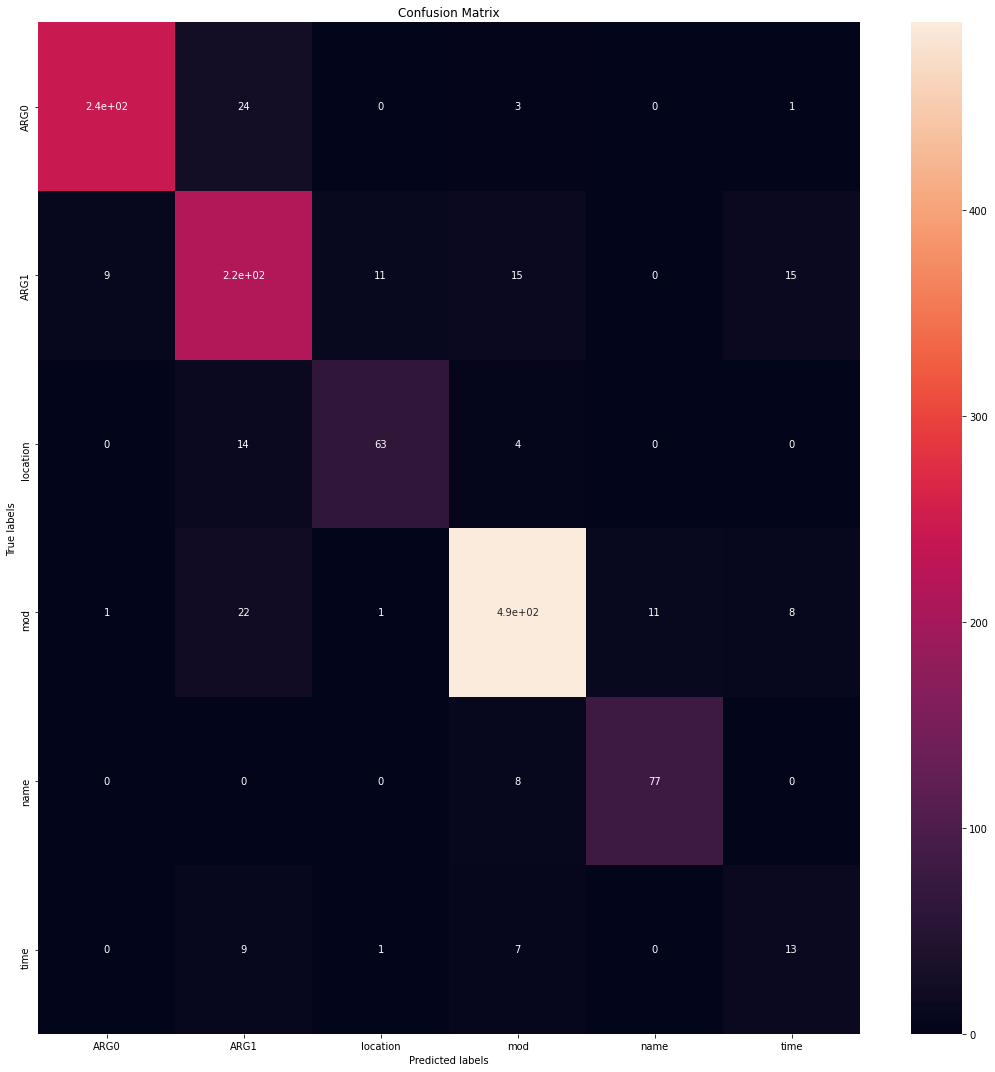

In [48]:
y_test_pred = best_model.predict(np.array(X_test_processed))
performance = get_metrics(label_encoder.transform(y_test), y_test_pred, label_encoder)
cm = confusion_matrix(label_encoder.transform(y_test), y_test_pred)

print_performance_metrics(performance, label_encoder.classes_)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, label_encoder.inverse_transform(y_test_pred), average=None, labels=label_encoder.classes_)
print('label_encoder.classes_\t',label_encoder.classes_)
print('precision\t\t',precision)
print('recall\t\t\t',recall)
print('fscore\t\t\t',fscore)
print('support\t\t\t',support)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.tight_layout()
plt.show()

In [49]:
predictions = create_pediction_graph(X_test, y_test_pred)
amr_graphs = []
for idx, prediction in enumerate(predictions):
    graph = create_amr_graph_from_prediction(prediction)
    amr_graphs.append(graph)

save_amr_graphs(amr_graphs, amr_test_prediction_path)

#### Show Test SMATCH score
Hasil Run
Pair Prediction : 0.67  
Label Prediction : ? ini berapa dan dimana    
Smatch : 0.79  
Zhang : ?  

Ini bandingin dengan Laporan Adylan  
Pair prediction : Kalimat - Dep Parse - Filter - Akurasi Pair (pair ini apa?) : 0.72  
Label prediction : 0.819  
Smatch : 0.82  
Zhang : 0.758  

In [50]:
!python tools/smatch/smatch.py -f data/test/test.pred.txt data/test/test.txt --pr --significant 3

Precision: 0.745
Recall: 0.839
F-score: 0.790


### Test Berita


In [51]:
TEST_BERITA_DIR = "data/raw/test/"
TEST_BERITA_FILE_NAMES = ["b-salah-darat.csv","c-gedung-roboh.csv","d-indo-fuji.csv", "f-bunuh-diri.csv", "g-gempa-dieng.csv"]
TEST_BERITA_FILE_PATHS = [TEST_BERITA_DIR + "labeled_df_"+ filename for filename in TEST_BERITA_FILE_NAMES]

In [52]:
for filepath in TEST_BERITA_FILE_NAMES:
    topic = filepath.split('.')[0]
    print(topic)
    print()
    
    test_berita_filepath = TEST_BERITA_DIR+"labeled_df_"+filepath
    test_dependency_features_df = pd.read_csv(test_berita_filepath)
    X_test, y_test = test_dependency_features_df.drop(['label'], axis=1), test_dependency_features_df['label']

    filtered_X_test = feature_selection(X_test, feature_filter_type)
    X_test_processed = preprocess(filtered_X_test, word_vec, one_hot_encoder)
    
    y_test_pred = best_model.predict(np.array(X_test_processed))
    performance = get_metrics(label_encoder.transform(y_test), y_test_pred, label_encoder)
    cm = confusion_matrix(label_encoder.transform(y_test), y_test_pred)

    print_performance_metrics(performance, label_encoder.classes_)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, label_encoder.inverse_transform(y_test_pred), average=None, labels=label_encoder.classes_)
    print(label_encoder.classes_)
    print(precision)
    print(recall)
    print(fscore)
    print(support)

#     ax= plt.subplot()
#     sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
#     # labels, title and ticks
#     ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#     ax.set_title('Confusion Matrix'); 
#     ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
#     plt.show()
    
    predictions = create_pediction_graph(X_test, y_test_pred)
    amr_graphs = []
    for idx, prediction in enumerate(predictions):
        graph = create_amr_graph_from_prediction(prediction)
        amr_graphs.append(graph)

    amr_output_path = TEST_BERITA_DIR+'amr_output_'+ topic
    save_amr_graphs(amr_graphs, amr_output_path)
    amr_test_path = TEST_BERITA_DIR+topic+".txt"
    
    !python tools/smatch/smatch.py -f {amr_output_path}.pred.txt {amr_test_path} --pr --significant 3

b-salah-darat

Accuracy: 0.681
F1 Micro : 0.681
F1 Macro: 0.503
SMATCH: 0.000
['ARG0' 'ARG1' 'location' 'mod' 'name' 'time']
[0.85294118 0.69387755 0.62857143 0.69491525 0.37931034 0.        ]
[0.70731707 0.50746269 0.66666667 0.89912281 0.1641791  0.        ]
[0.77333333 0.5862069  0.64705882 0.78393881 0.22916667 0.        ]
[ 41  67  33 228  67   6]
D:\miniconda3\envs\amr\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['ARG0' 'ARG1' 'location' 'mod' 'name' 'time'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
D:\miniconda3\envs\amr\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Prec